# Example application: adult-income task

Please refer to the more annotated https://pglpm.github.io/ADA511/example_opm1.html

Let's illustrate the example workflow described in [§ @sec-opm-workflow] with a toy, but not too simplistic, example, based on the [adult-income dataset](https://archive.ics.uci.edu/dataset/2/adult).


All code functions and data files are in the directory\
[https://github.com/pglpm/ADA511/tree/master/code/OPM-nominal](https://github.com/pglpm/ADA511/tree/master/code/OPM-nominal)

We start loading the R libraries and functions needed at several stages. You need to have installed^[This is done with the [`install.packages()` function](https://rdrr.io/r/utils/install.packages.html).] the packages [*data.table*](https://cran.r-project.org/package=data.table), [*extraDistr*](https://cran.r-project.org/package=extraDistr), [*foreach*](https://cran.r-project.org/package=foreach), [*khroma*](https://cran.r-project.org/package=khroma). Make sure you have saved all source files and data files in the same directory.

In [4]:
library('data.table')
library('extraDistr')
library('foreach')
library('khroma')

source('tplotfunctions.R')
source('guessmetadata.R')
source('buildagent.R')
source('infer.R')
source('decide.R')
source('mutualinfo.R')
source('rF.R')
source('plotFsamples1D.R')

## Modify '10' below if the plots are too large or too small
options(repr.plot.width=10*sqrt(2), repr.plot.height=10)

\

## Define the task

The main task is to infer whether a USA citizen earns less (≤) or more (>) than USD 50 000/year, given a set of characteristics of that citizen. In view of later workflow stages, let's note a couple of known and unknown facts to delimit this task in a more precise manner:

- Given the flexibility of the agent we shall use, we can generalize the task: to infer any subset of the set of characteristics, given any other subset. In other words, we can choose the predictand and predictor variates for any new citizen. Later on we shall also extend the task to making a concrete decision, based on utilities relevant to that citizen.
    
	This flexibility is also convenient because no explanation is given as to *what purpose* the income should be guessed.

- The training data come from a 1994 census, and our agent will use an exchangeable belief distribution about the population. The value of the USD and the economic situation of the country changes from year to year, as  well as the informational relationships between economic and demographic factors. For this reason the agent should be used to draw inferences about at most one or two years around 1994. Beyond such time range the exchangeability assumption is too dubious and risky.

- The [USA population in 1994 was around 260 000 000](https://www.macrotrends.net/countries/USA/united-states/population), and we shall use around 11 000 training data. The population size can therefore be considered approximately infinite.

\

## Collect & prepare background info

### Variates and domains

The variates to be used must be of nominal type, because our agent's background beliefs (represented by the Dirichlet-mixture distribution) are only appropriate for nominal variates. In this toy example we simply discard all original non-nominal variates. These included some, such as age, that would surely be relevant for this task. As a different approach, we could have coarsened each non-nominal variate into three or four range values, so that treating it as nominal would have been an acceptable approximation.

First, create a preliminary metadata file by running the function `guessmetadata()` on the training data [`train-income_data_example.csv`](https://github.com/pglpm/ADA511/blob/master/code/OPM-nominal/train-income_data_example.csv):

In [5]:
guessmetadata(data='train-income_data_example.csv',
              file='preliminary.csv')

Inspect the resulting file `preliminary.csv` and check whether you can alter it to add additional background information.

As an example, note that domain of the $\mathit{native\_country}$ variate does not include $\verb|Norway|$ or $\verb|Netherlands|$. Yet it's extremely likely that there were some native Norwegian or Dutch USA citizens in 1994; maybe too few to have been sampled into the training data. Let's add these two values to the list of domain values, and increase the domain size of $\mathit{native\_country}$ from 40 to 42. The resulting, updated metadata file has already been saved as [`meta_income_data_example.csv`](https://github.com/pglpm/ADA511/blob/master/code/OPM-nominal/meta_income_data_example.csv).

### Agent's parameters $k_{mi}, k_{ma}$

How many data should the agent learn in order to appreciably change its initial beliefs about the variates above, for the USA 1994 population? Let's put an upper bound at around 1 000 000 (that's roughly 0.5% of the whole population) with $k_{ma}=20$, and a lower bound at 1 with $k_{mi}=0$; these are the default values. We shall see later what the agent suggests might be a reasonable amount of training data.

\

## Collect & prepare training data

The 11 306 training data have been prepared by including only nominal variates, and discarding datapoints with partially missing data (although the function `buildagent()` discards such incomplete datapoints automatically). The resulting file is [`test-income_data_example.csv`](https://github.com/pglpm/ADA511/blob/master/code/OPM-nominal/test-income_data_example.csv).

\

## Prepare OPM agent

For the sake of this example we shall prepare two agents with the same background information:

- `opm10`, trained with 10 training datapoints

- `opmall`, trained with all 11 306 training datapoints

Prepare and train each with the `buildagent()` function:

In [6]:
## temporarily load all training data
traindata <- fread('train-income_data_example.csv', header=TRUE)

## feed first 10 datapoints to an agent
opm10 <- buildagent(metadata='meta_income_data_example.csv',
                    data=traindata[1:10])

## delete training data for memory efficiency
rm(traindata)


opmall <- buildagent(metadata='meta_income_data_example.csv',
                     data='train-income_data_example.csv')

\

We can peek into the internal structure of these "agent objects" with `str()`

In [7]:
str(opmall)

List of 4
 $ counts   : num [1:7, 1:16, 1:7, 1:14, 1:6, 1:5, 1:2, 1:42, 1:2] 0 0 0 0 0 0 0 0 0 0 ...
  ..- attr(*, "dimnames")=List of 9
  .. ..$ workclass     : chr [1:7] "Federal-gov" "Local-gov" "Private" "Self-emp-inc" ...
  .. ..$ education     : chr [1:16] "10th" "11th" "12th" "1st-4th" ...
  .. ..$ marital_status: chr [1:7] "Divorced" "Married-AF-spouse" "Married-civ-spouse" "Married-spouse-absent" ...
  .. ..$ occupation    : chr [1:14] "Adm-clerical" "Armed-Forces" "Craft-repair" "Exec-managerial" ...
  .. ..$ relationship  : chr [1:6] "Husband" "Not-in-family" "Other-relative" "Own-child" ...
  .. ..$ race          : chr [1:5] "Amer-Indian-Eskimo" "Asian-Pac-Islander" "Black" "Other" ...
  .. ..$ sex           : chr [1:2] "Female" "Male"
  .. ..$ native_country: chr [1:42] "Cambodia" "Canada" "China" "Columbia" ...
  .. ..$ income        : chr [1:2] "<=50K" ">50K"
 $ alphas   : num [1:21] 1 2 4 8 16 32 64 128 256 512 ...
 $ auxalphas: num [1:21] -160706 -157643 -154588 -15154

this shows that each agent is encoded as a list of four objects:

- the array `counts`, containing the counts $\green\# z$
- the vector `alphas`, containing the values of $2^k$
- the vector `auxalphas`, containing the (logarithm of) the multiplicative factors ([§ @sec-code-computations])
- the vector `palphas`, containing the updated probabilities about the required amount of training data

The agent has internally guessed how many training data should be necessary to affect its prior beliefs. We can peek at its guess by plotting the `alphas` parameters against the `palphas` probabilities:

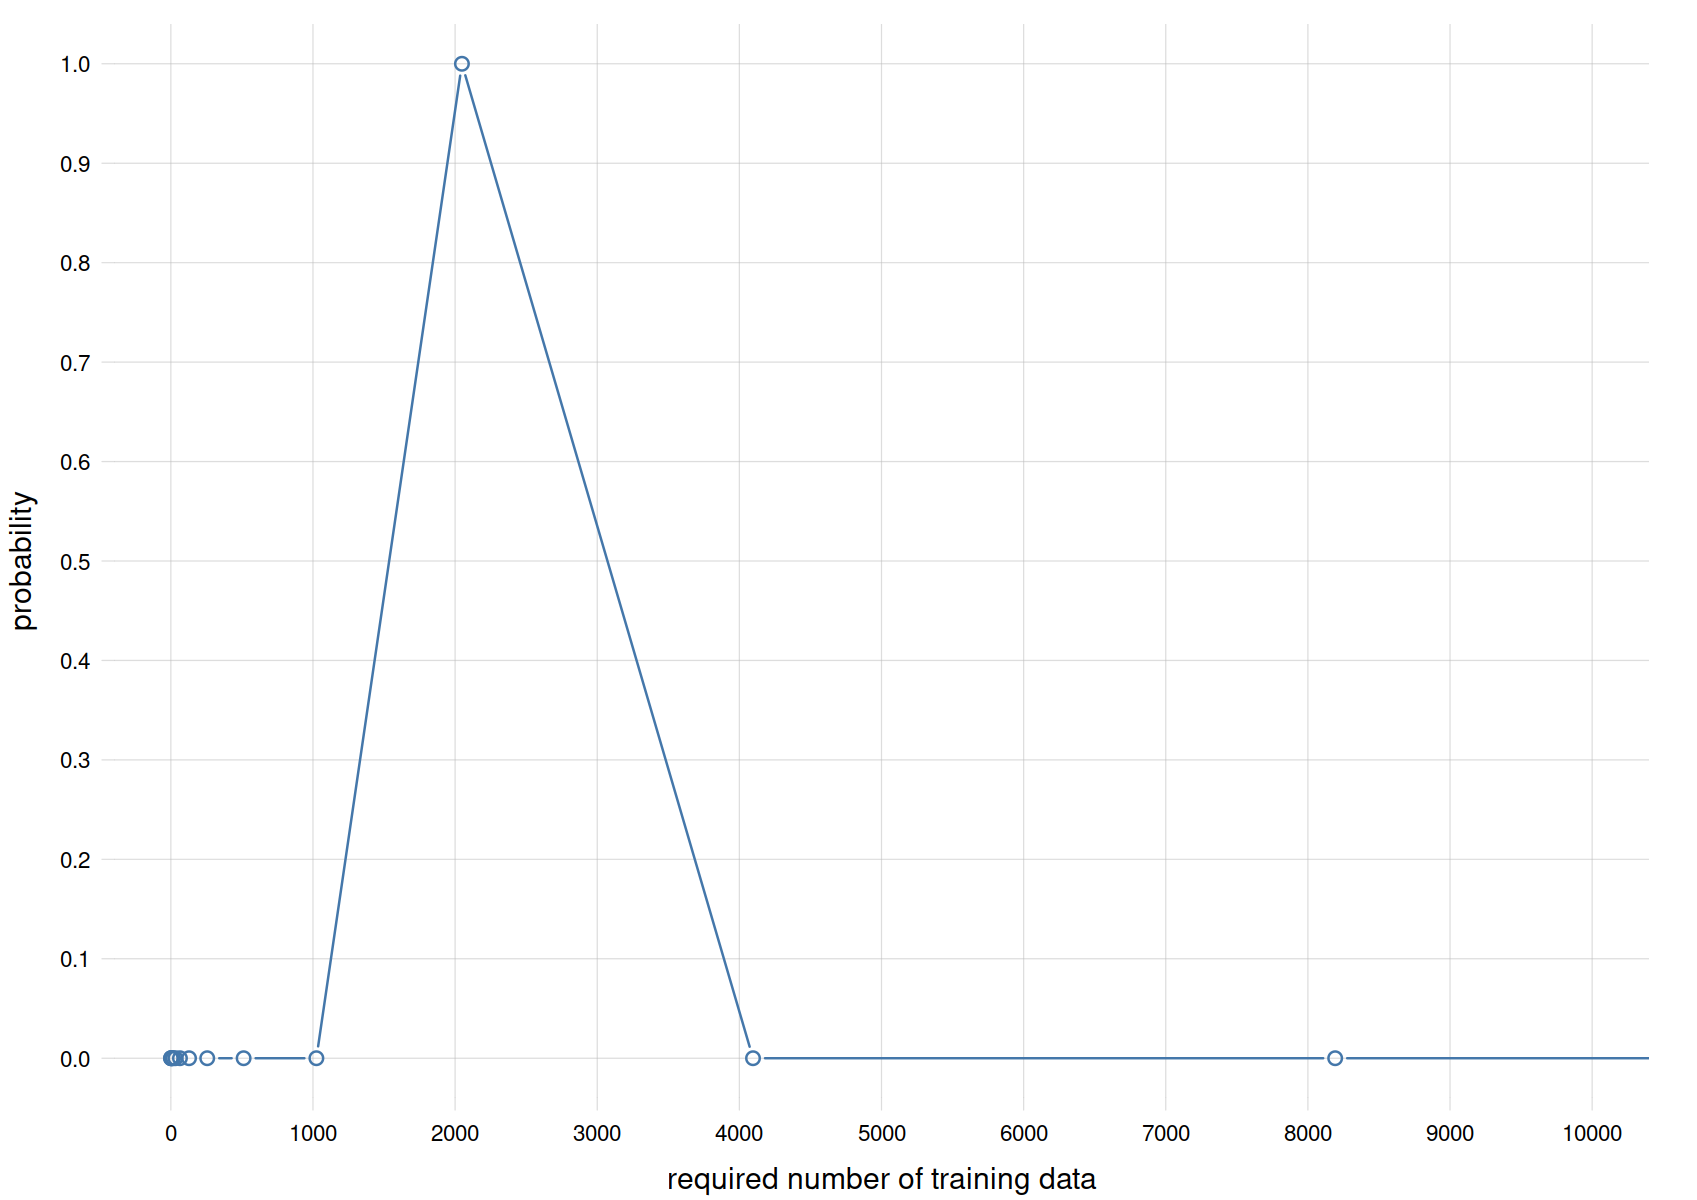

In [8]:
tplot(x=opmall$alphas, y=opmall$palphas, type='b',
      xlim=c(0, 10000), ylim=c(0, NA),
      xlab='required number of training data', ylab='probability')

The most probable amount seems to be of the order of magnitude of 2000 units.

Note that you can see the complete list of variates and their domains by simply calling `dimnames(opmall$counts)` (or any relevant agent-object name instead of `opmall`). Here is the beginning of the list:

In [9]:
head(dimnames(opmall$counts))

$workclass
[1] "Federal-gov"      "Local-gov"        "Private"          "Self-emp-inc"    
[5] "Self-emp-not-inc" "State-gov"        "Without-pay"     

$education
 [1] "10th"         "11th"         "12th"         "1st-4th"      "5th-6th"     
 [6] "7th-8th"      "9th"          "Assoc-acdm"   "Assoc-voc"    "Bachelors"   
[11] "Doctorate"    "HS-grad"      "Masters"      "Preschool"    "Prof-school" 
[16] "Some-college"

$marital_status
[1] "Divorced"              "Married-AF-spouse"     "Married-civ-spouse"   
[4] "Married-spouse-absent" "Never-married"         "Separated"            
[7] "Widowed"              

$occupation
 [1] "Adm-clerical"      "Armed-Forces"      "Craft-repair"      "Exec-managerial"  
 [5] "Farming-fishing"   "Handlers-cleaners" "Machine-op-inspct" "Other-service"    
 [9] "Priv-house-serv"   "Prof-specialty"    "Protective-serv"   "Sales"            
[13] "Tech-support"      "Transport-moving" 

$relationship
[1] "Husband"        "Not-in-family"  "Other-relative" "Own-child"     
[5] "Unmarried"      "Wife"          

$race
[1] "Amer-Indian-Eskimo" "Asian-Pac-Islander" "Black"              "Other"             
[5] "White"

\

## Application and exploration

### Application: only predictands

Our two agents are ready to be applied to new instances.

Before applying them, let's check some of their inferences, and see if we find anything unconvincing about them. If we find something unconvincing, it means that the background information we provided to the agent doesn't match the one in our intuition. Then there are two or three possibilities: our intuition is misleading us and need correcting; or we need to go back to stage [*Collect & prepare background info*]{.blue} and correct the background information given to the agent; or a combination of these two possibilities.

We ask the `opm10` agent to forecast the $\mathit{income}$ of the next unit, using the `infer()` function:

In [9]:
infer(agent=opm10, predictand='income')

income
   <=50K     >50K 
0.506288 0.493712

This agent gives a slightly larger probability to the $\verb|<=50K|$ case. Using the function `plotFsamples1D()` we can also inspect the `opm10`-agent's belief about the frequency distribution of $\mathit{income}$ for the full population. This belief is represented by a generalized scatter plot of 200 representative frequency distributions, represented as the [grey lines]{.grey}:

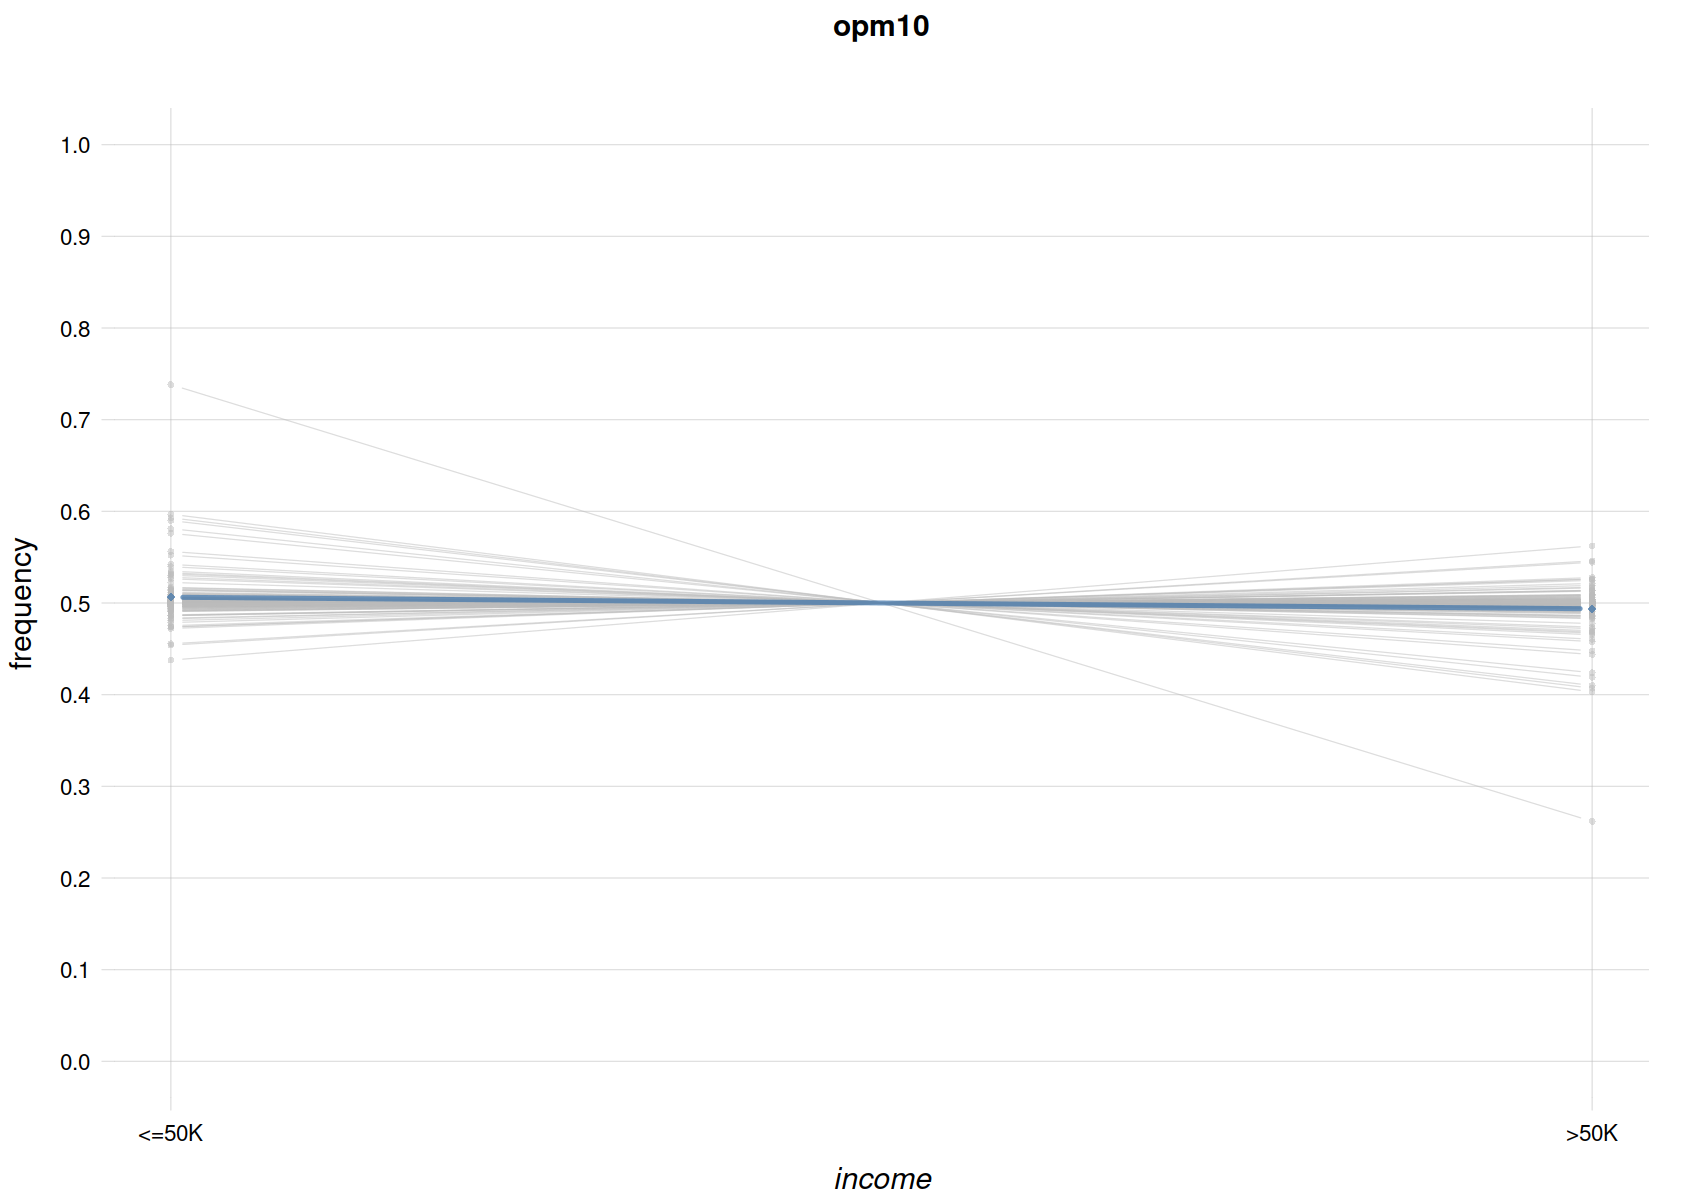

In [10]:
plotFsamples1D(agent=opm10,
               n=200, # number of example frequency distributions
               predictand='income',
               ylim=c(0,1), # y-axis range
               main='opm10') # plot title

where the [blue line]{.blue} is the probability distribution previously calculated with the `infer()` function.

This plot expresses the `opm10`-agent's belief that future training data might lead to even higher probabilities for $\verb|<=50K|$. But note that the agent is not excluding the possibility of lower probabilities.


Let's visualize the beliefs of the `opmall`-agent, trained with the full training dataset:

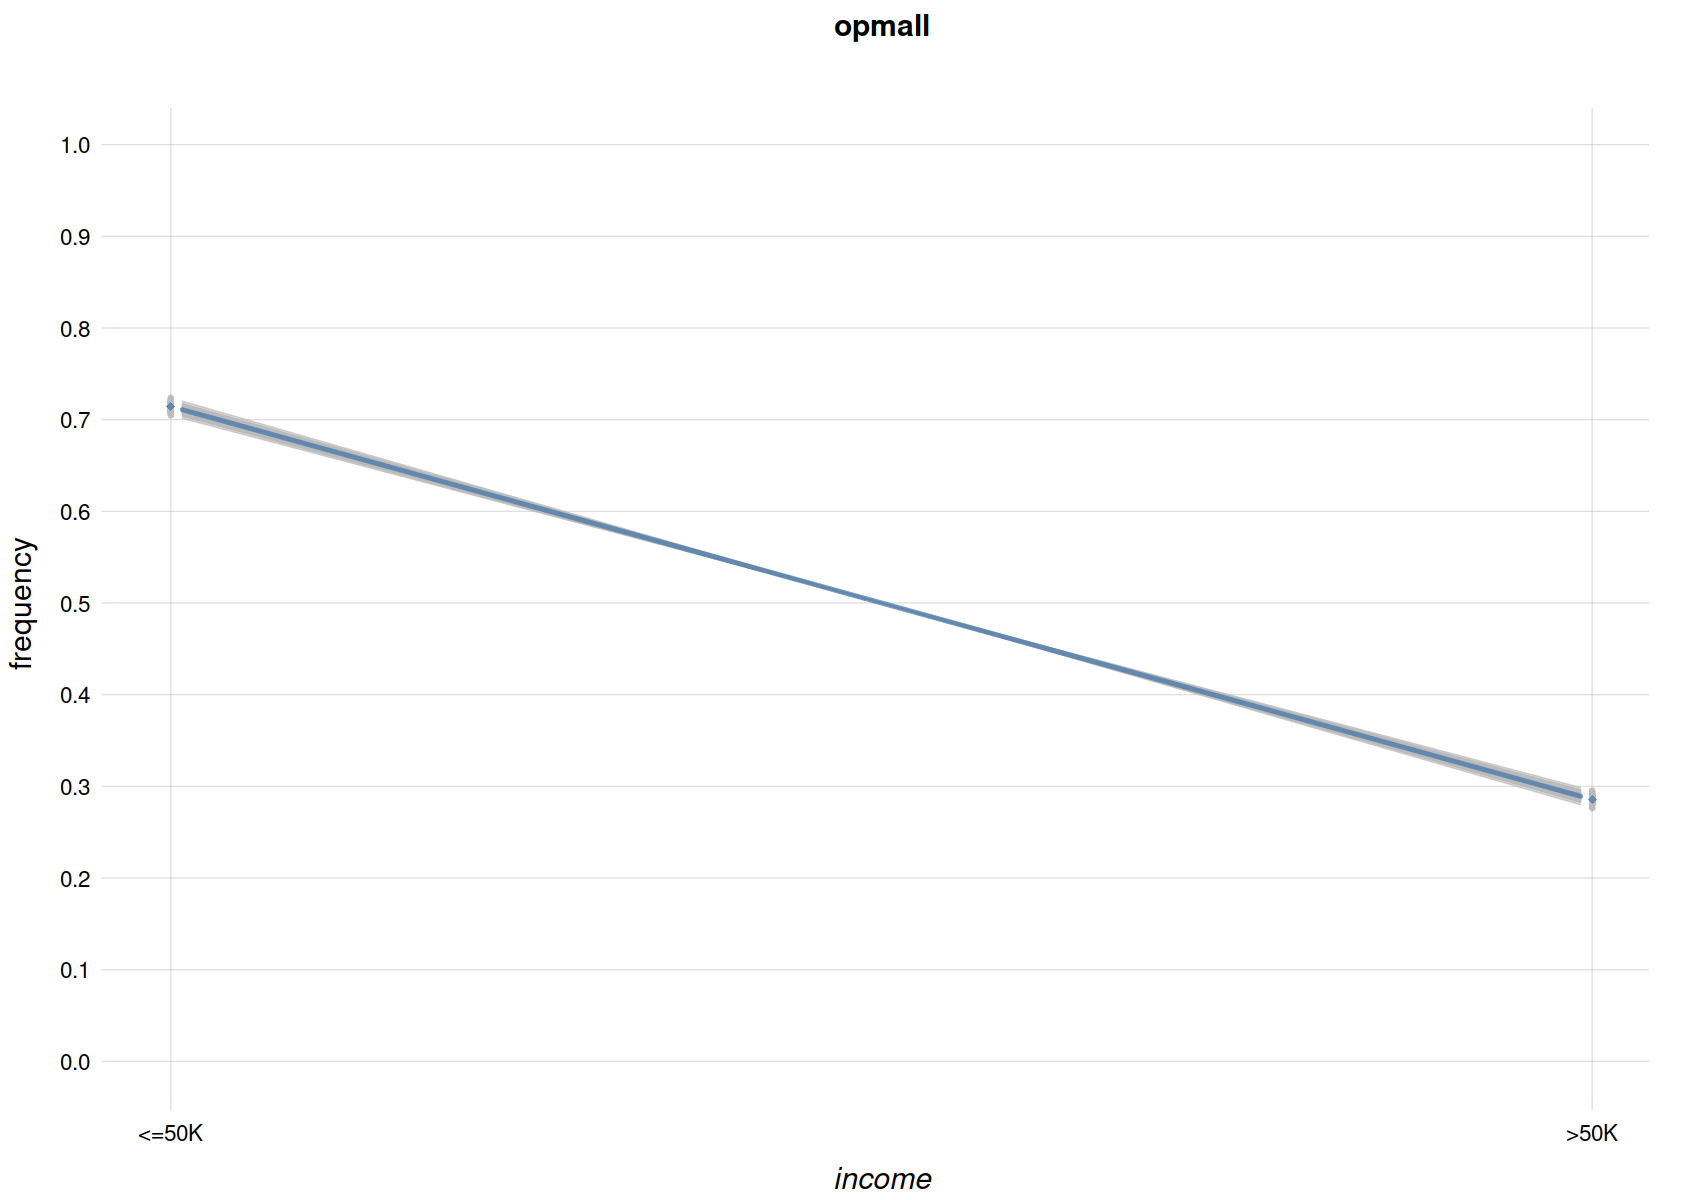

In [11]:
plotFsamples1D(agent=opmall, n=200, predictand='income',
               ylim=c(0,1), main='opmall')

The probability that the next unit has $\mathit{income}\mathclose{}\mathord{\nonscript\mkern0mu\textrm{\small=}\nonscript\mkern0mu}\mathopen{}\verb|<=50|$ is now above 70%. Also note that the `opmall`-agent doesn't believe that this probability would change appreciably if more training data were provided.

\

We can perform a similar exploration for any other variate. Let's take the $\mathit{race}$ variate for example:


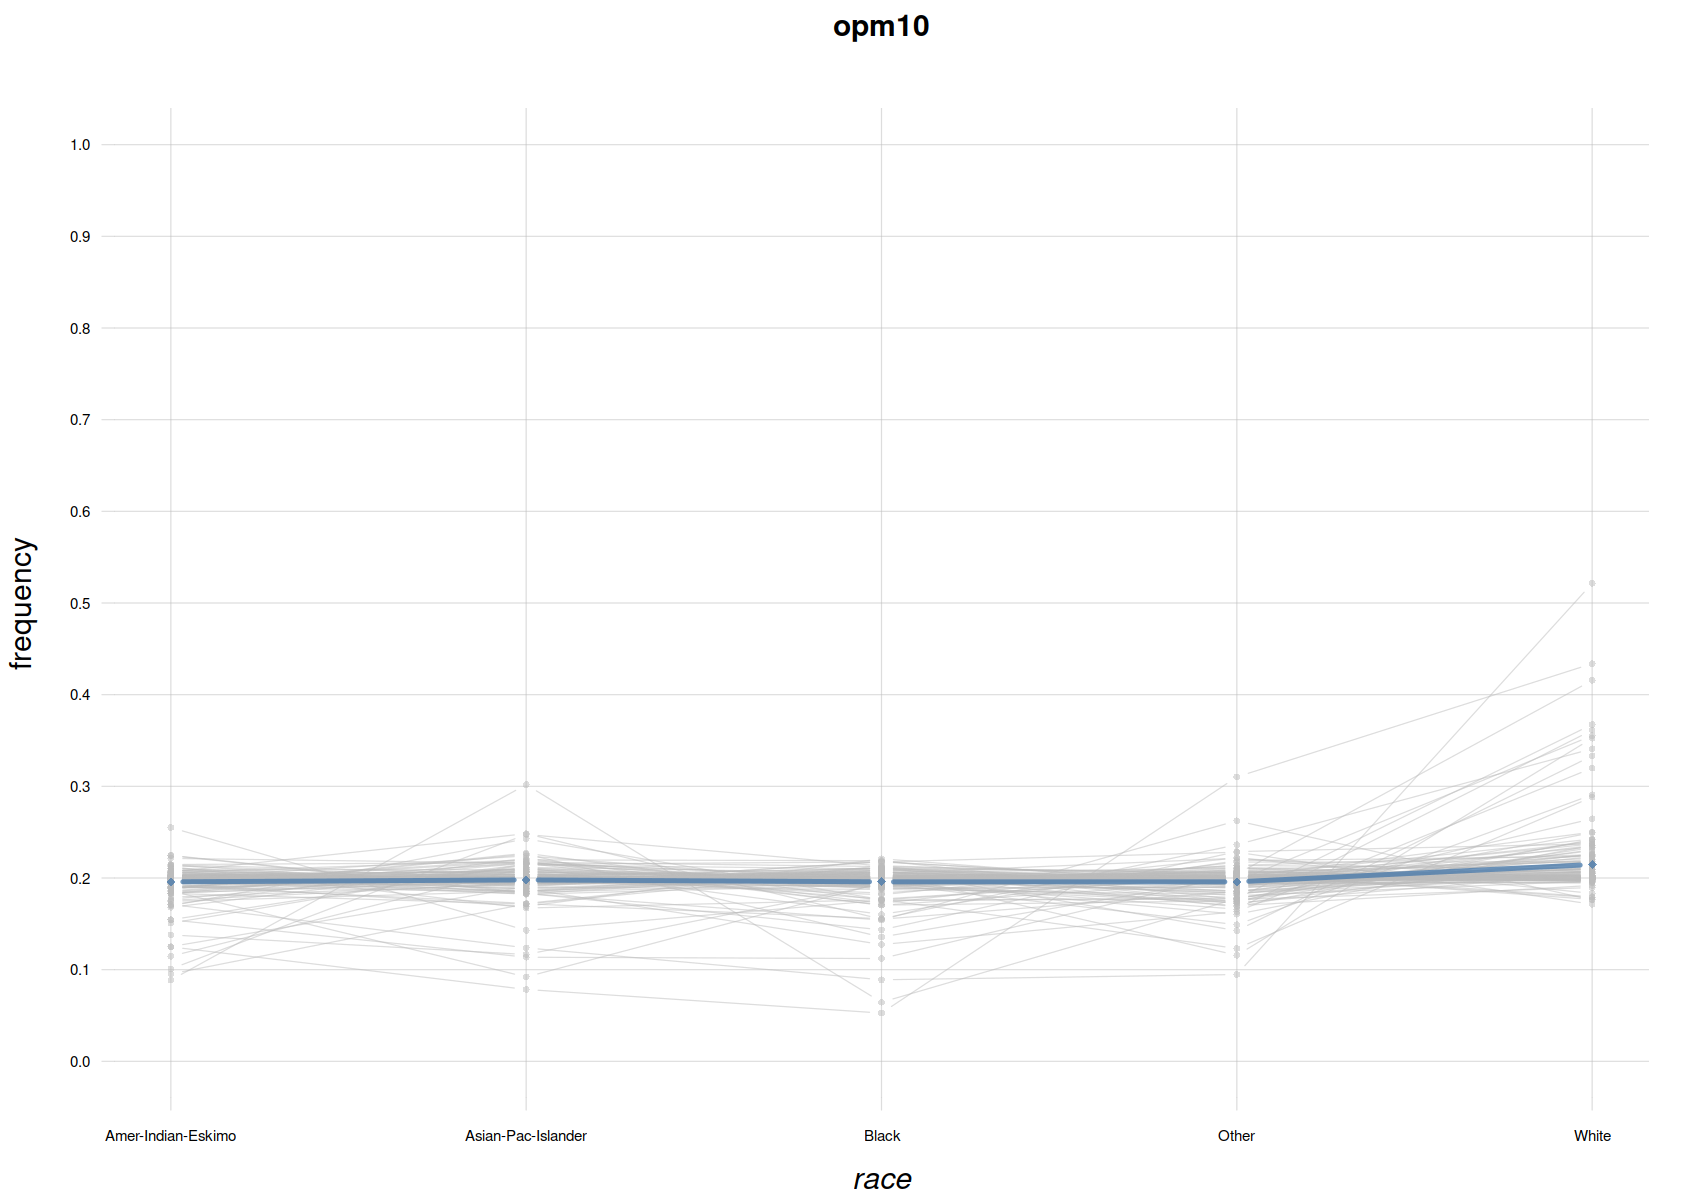

In [12]:
plotFsamples1D(agent=opm10, n=200, predictand='race',
               ylim=c(0,1), main='opm10',
               cex.axis=0.75) # smaller axis-font size

Note again how the little-trained `opm10`-agent has practically uniform beliefs. But it's also expressing the fact that future training data will probably increase the probability of $\mathit{race}\mathclose{}\mathord{\nonscript\mkern0mu\textrm{\small=}\nonscript\mkern0mu}\mathopen{}\verb|White|$.

This is corroborated by the fully-trained agent:


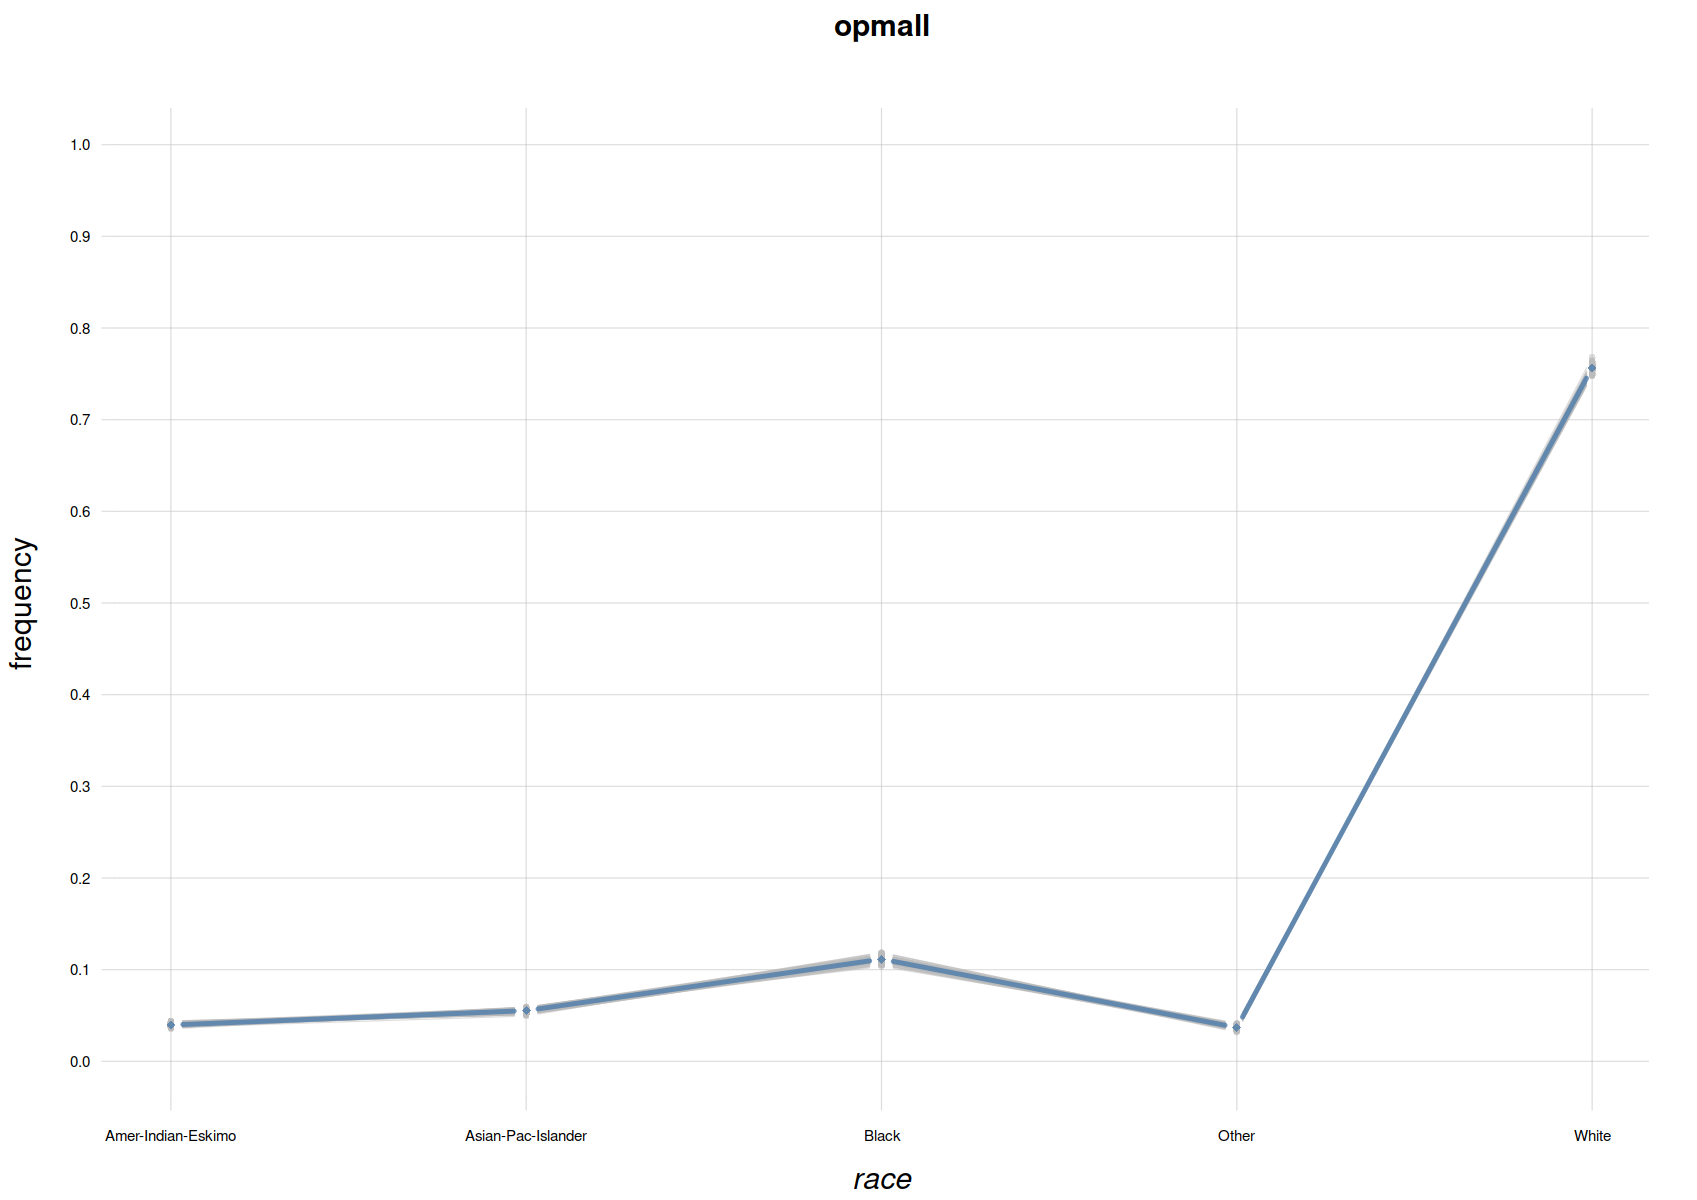

In [13]:
plotFsamples1D(agent=opmall, n=200, predictand='race',
               ylim=c(0,1), main='opmall', cex.axis=0.75)

\

These checks are satisfying, but it's good to examine their agreement or disagreement with our intuition. Examine the last plot for example. The `opmall` agent has very firm beliefs (no spread in the [grey lines]{.grey}) about the full-population distribution of $\mathit{race}$. Do you think its beliefs are too firm, after 11 000 datapoints? would you like the agent to be more "open-minded"? In that case you should go back to the [*Collect & prepare background info*]{.blue} stage, and for example modify the parameters $k_{mi}, k_{ma}$, then re-check. Or you could even try an agent with a different initial belief distribution.

In making this kind of considerations it's important to keep in mind what we learned and observed in previous chapters:


#### **Our goal: optimality, not "success"**

Remember ([§ @sec-optimality] and [§ @sec-probability-def]) that a probability represents the *rational* degree of belief that an agent should have *given the particular information available*. We can't judge a probability from the value it assigns to something we later learn to be true -- because according to the information available it could be more rational (and optimal) to consider that something implausible (recall the example in [§ @sec-probability-def] of an object falling from the sky as we cross the street).

From this point of view we should be wary of comparing the probability of something with our a-posteriori knowledge about it.

\

#### **The data cannot speak for themselves**

We could build an agent that remains more "open-minded" (more spread in the [grey lines]{.grey}), having received *exactly the same* training data. This "open-mindedness" therefore cannot be determined by the training data. Once more this shows that data *cannot* "speak for themselves" ([§ @sec-underlying-distribution]).



\

### Application: specifying predictors

Let's now draw inferences by specifying some predictors.

We ask the `opm10` agent to forecast the $\mathit{income}$ of a new unit, given that the unit is known to have $\mathit{occupation}\mathclose{}\mathord{\nonscript\mkern0mu\textrm{\small=}\nonscript\mkern0mu}\mathopen{}\verb|Exec-managerial|$ and $\mathit{sex}\mathclose{}\mathord{\nonscript\mkern0mu\textrm{\small=}\nonscript\mkern0mu}\mathopen{}\verb|Male|$ (two predictor variates). What would you expect?

The `opm10`-agent's belief about the unit -- as well as about the *full subpopulation* ([§ @sec-subpopulations]) of units having those predictors -- is shown in the following plot:

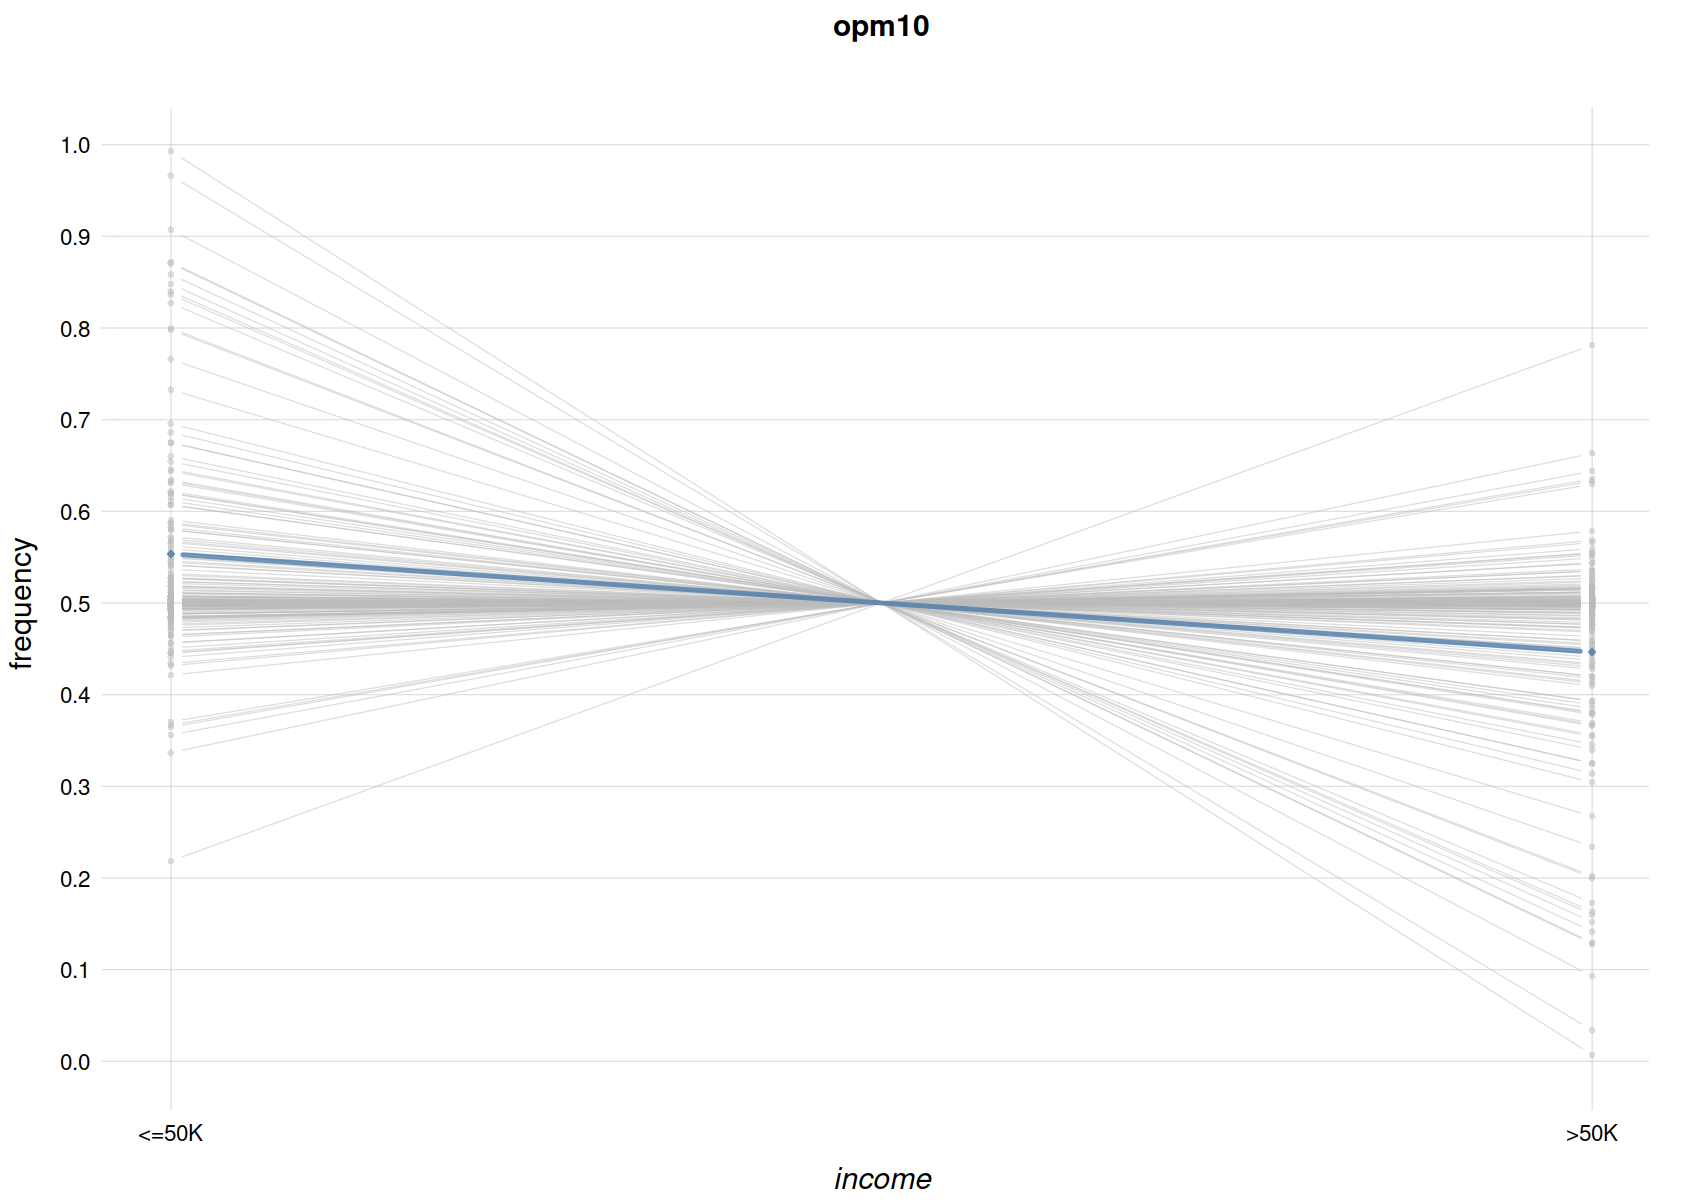

In [14]:
plotFsamples1D(agent=opm10, n=200,
               predictand='income',
               predictor=list(occupation='Exec-managerial',
                              sex='Male'),
               ylim=c(0,1), main='opm10')

Note how the `opm10`-agent still slightly higher probability to $\mathit{income}\mathclose{}\mathord{\nonscript\mkern0mu\textrm{\small=}\nonscript\mkern0mu}\mathopen{}\verb|<=50|$, but at the same time it is quite uncertain about the subpopulation frequencies; more than if the predictor had not been specified. That is, according to this little-trained agent there could be large variety of possibilities *within this specific subpopulation*.

The `opmall`-agent's beliefs are shown below:

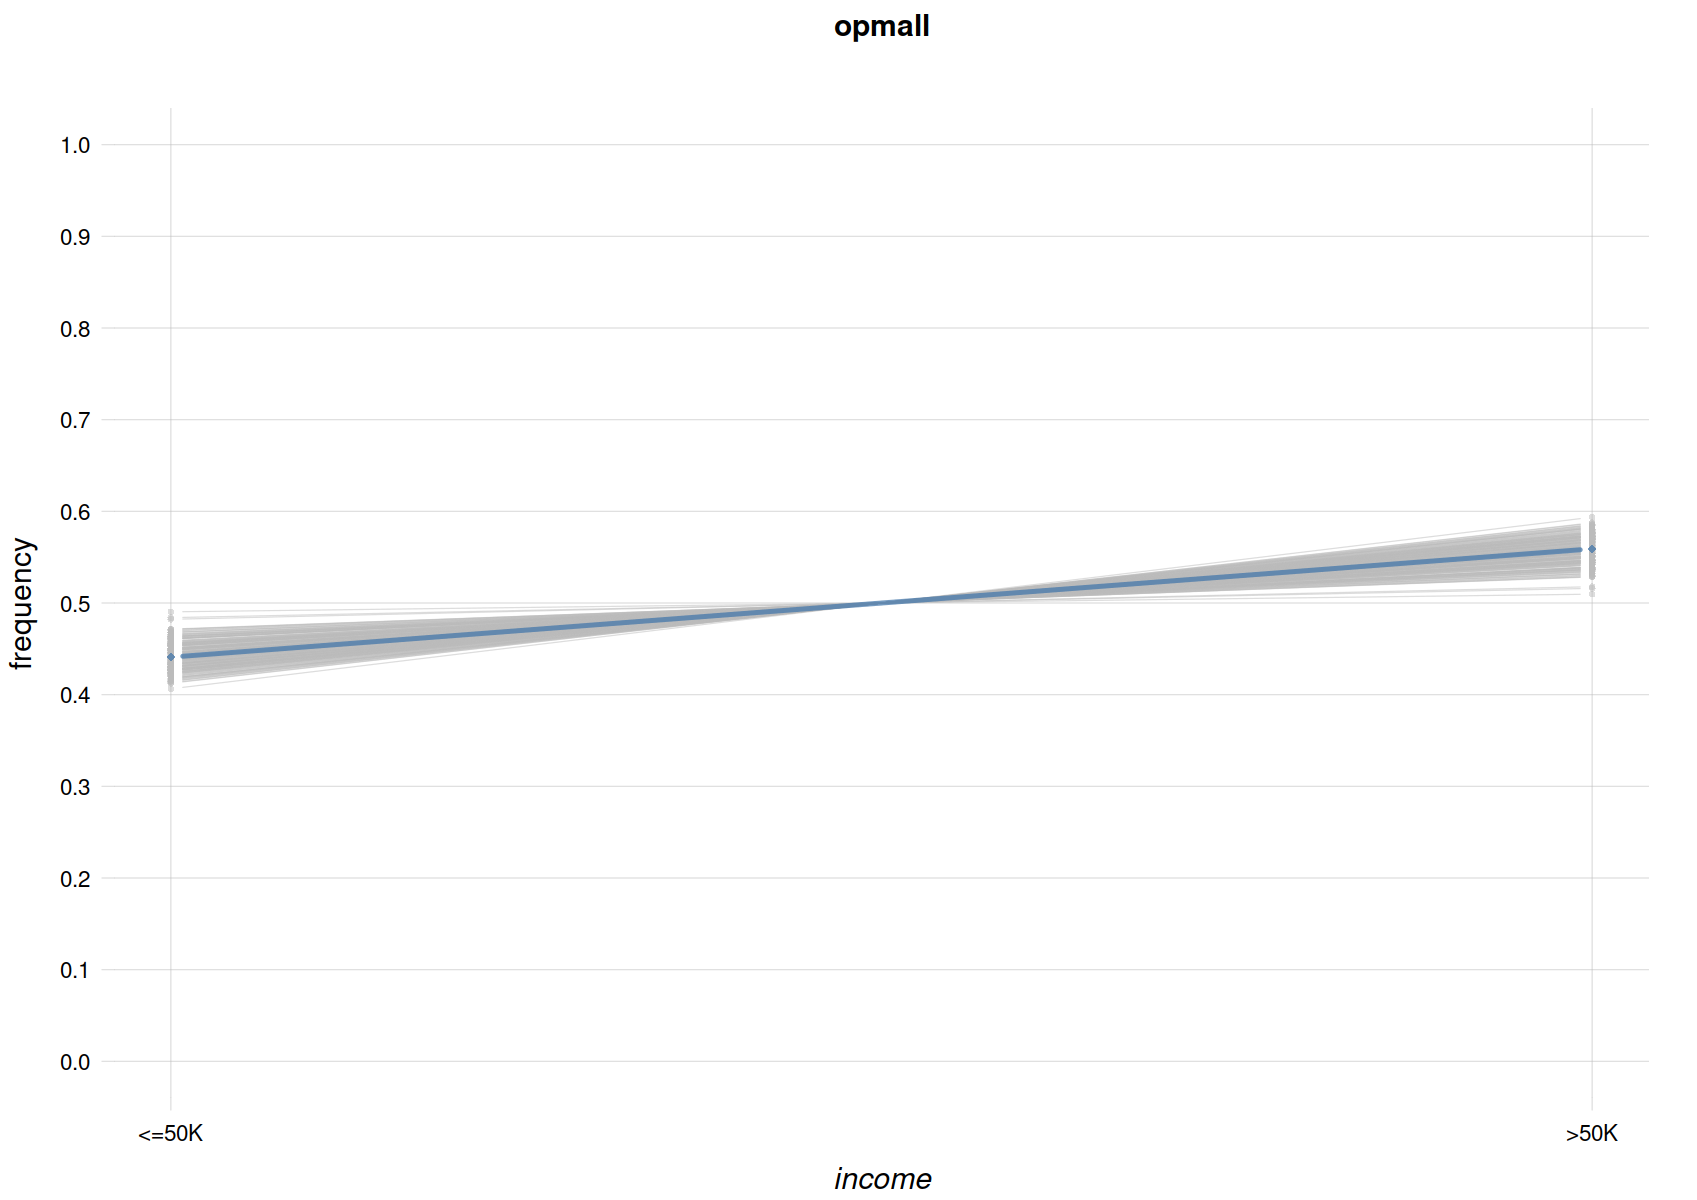

In [15]:
plotFsamples1D(agent=opmall, n=200,
               predictand='income',
               predictor=list(occupation='Exec-managerial',
                              sex='Male'),
               ylim=c(0,1), main='opmall')

it believes with around 55% probability that such a unit would have higher, $\verb|>50K|$ income. The representative subpopulation-frequency distributions in grey indicate that this belief is unlikely to be changed by new training data.

\

Let's now see an example of our agent's versatility by switching predictands and predictors. We tell the `opmall`-agent that the new unit has $\mathit{income}\mathclose{}\mathord{\nonscript\mkern0mu\textrm{\small=}\nonscript\mkern0mu}\mathopen{}\verb|>50|$, and ask it to infer the joint variate $(\mathit{occupation} \mathbin{\mkern-0.5mu,\mkern-0.5mu} \mathit{sex})$; let's present the results in rounded percentages:

In [16]:
result <- infer(agent=opmall,
                predictand=c('occupation', 'sex'),
                predictor=list(income='>50K'))

round(result * 100, 1) # round to one decimal

,Female,Male
Adm-clerical,3.1,4.1
Armed-Forces,1.0,1.0
Craft-repair,1.1,9.4
Exec-managerial,3.6,16.0
Farming-fishing,1.0,2.1
Handlers-cleaners,1.0,1.6
Machine-op-inspct,1.1,3.1
Other-service,1.6,1.8
Priv-house-serv,1.0,1.0
Prof-specialty,4.8,14.7


It returns a 14 × 2 table of joint probabilities. The most probable combinations are $(\verb|Exec-managerial|, \verb|Male|)$ and $(\verb|Prof-specialty|, \verb|Male|)$.

### The `rF()` function

This function generates **full-population** frequency distributions (even for subpopulations) that are probable according to the data. It is used internally by `plotFsamples1D()`, which plots the generated frequency distributions as [grey lines]{.grey}.

Let's see, as an example, three samples of how the full-population frequency distribution for $\mathit{sex} \mathbin{\mkern-0.5mu,\mkern-0.5mu} \mathit{income}$ (jointly) could be:

In [17]:
result <- rF(n=3, # number of samples
             agent=opmall, 
             predictand=c('sex', 'income'))

## name the samples
dimnames(result)[1] <- list(samples=paste0('#',1:3))

## permute & print so that samples are the last array dimension
print(aperm(result) * 100)

, , sample = #1

       sex
income    Female    Male
  <=50K 27.46694 43.0545
  >50K   7.35948 22.1191

, , sample = #2

       sex
income    Female    Male
  <=50K 28.10536 43.0343
  >50K   7.07763 21.7827

, , sample = #3

       sex
income    Female    Male
  <=50K 27.94008 43.5205
  >50K   6.91542 21.6240



These possible full-population frequency distributions can be used to assess how much the probabilities we find could change, if we collected a much, much larger amount of training data. Here is an example:

We generate 1000 frequency distributions for $(\mathit{occupation} \mathbin{\mkern-0.5mu,\mkern-0.5mu} \mathit{sex})$ given $\mathit{income}\mathclose{}\mathord{\nonscript\mkern0mu\textrm{\small=}\nonscript\mkern0mu}\mathopen{}\verb|>50K|$, and then take the standard deviations of the samples as a rough measure of how much the probabilities we calculated a couple of cells above could change:

In [18]:
freqsamples <- rF(n=1000,
                  agent=opmall,
                  predictand=c('occupation', 'sex'),
                  predictor=list(income='>50K'))

variability <- apply(freqsamples,
                     c('occupation','sex'), # which dimensions to apply
                     sd) # function to apply to those dimensions

round(variability * 100, 2) # round to two decimals

,Female,Male
Adm-clerical,0.29,0.32
Armed-Forces,0.17,0.16
Craft-repair,0.16,0.49
Exec-managerial,0.30,0.59
Farming-fishing,0.16,0.24
Handlers-cleaners,0.16,0.20
Machine-op-inspct,0.17,0.28
Other-service,0.20,0.22
Priv-house-serv,0.16,0.15
Prof-specialty,0.34,0.57


the agent believes (at around 68%) that the current probability wouldn't change more than about ±0.5%.


\

The inferences above were partially 
meant as checks, but we see that we can actually ask our agent a wide variety of questions about the full population, and do all sorts of association studies.



#### **No "test" or "validation" datasets used or needed**

The tests and explorations above were done without any "validation" or "test" datasets. This is because our agent is capable of calculating and showing its beliefs about the *full population* -- and therefore about future data.

The need for validation or test datasets with common machine-learning algorithms arise from the fact that full-population beliefs are hidden or, more commonly, not computed at all, in order to gain speed. The application of the trained machine-learning algorithm to a validation dataset is an approximate way of extracting such beliefs.


\

### Exploring the population properties: mutual information

In [§ @sec-entropy-mutualinfo] we introduced [*mutual information*]{.blue} as the information-theoretic measure of mutual relevance and association of two quantities or variates. For the present task, the `opmall`-agent can tell us the mutual information between any two sets of variates of our choice, with the function `mutualinfo()`.

For instance, let's calculate the mutual information between $\mathit{occupation}$ and $\mathit{marital\_status}$.

First we need the joint probability distribution for both variates, which the agent can calculate with `infer()`:

In [19]:
probs <- infer(agent=opmall,
               predictand=c('occupation', 'marital_status'))

This distribution is then used in the formula for the mutual information, implemented in `mutualinfo()`:

In [20]:
mutualinfo(probs=probs,
           A='occupation', B='marital_status')

[1] 0.0827823

It is a very low association: knowing either variate decreases the effective number of possible values of the other only $2^{0.0827823\,\mathit{Sh}} \approx 1.06$ times.

Now let's consider a scenario where, in order to save resources, we can use *only one* variate to infer the income. Which of the other variates should we prefer? We can calculate the mutual information between each of them, in turn, and $\mathit{income}$:

In [23]:
## list of all variates
variates <- names(dimnames(opmall$counts))

## list of all variates except 'income'
predictors <- variates[variates != 'income']

## prepare vector to contain the mutual information
relevances <- numeric(length(predictors))
names(relevances) <- predictors

## calculate, for each variate,
## the joint probability distribution 'probs'
## and then mutual information 'relevance' (in shannons)
## between 'income' and that variate
for(var in predictors){
    probs <- infer(agent=opmall, predictand=c('income',var))
    relevances[var] <- mutualinfo(probs=probs, A='income', B=var)
}

## output the mutual informations in decreasing order
print(sort(relevances, decreasing=TRUE))

marital_status   relationship      education     occupation      workclass 
    0.10074130     0.09046621     0.06332052     0.05506897     0.03002995 
native_country            sex           race 
    0.01925227     0.01456655     0.00870089 


If we had to choose *only one* variate to infer the outcome, on average it would be best to use $\mathit{marital\_status}$. Our last choice should be $\mathit{race}$.

----

## **EXERCISE**

Now consider the scenario where we must *exclude one variate* from the eight predictors, or, equivalently, we can only use seven variates as predictors. Which variate should we exclude?

Prepare a script similar to the one above: it calculates the mutual information between $\mathit{income}$ and the other predictors but with one omitted, omitting each of the eight in turn.

*Warning: this computation might require 10 or more minutes to complete.*

- Which single variate should not be omitted from the predictors? which single variate could be dropped?

- Do you obtain the same relevance ranking as in the "use-one-variate-only" scenario above?

----

## Example application to new data

Let's apply the `opmall`-agent to a test dataset with 33 914 new units. For each new unit, the agent:

- calculates the probability of $\mathit{income}\mathclose{}\mathord{\nonscript\mkern0mu\textrm{\small=}\nonscript\mkern0mu}\mathopen{}\verb|<=50|$, via the function `infer()`, using as predictors all variates except $\mathit{income}$

- chooses one of the two values $\set{\verb|<=50K|, \verb|>50K|}$, via the function `decide()`, trying to maximizing utilities corresponding to the accuracy metric

The function `decide()` will be described in more detail in the next chapters.

At the end we plot a histogram of the probabilities calculated for the new units, to check for instance for how many of the agent was sure (beliefs around 0% or 100%) or unsure (beliefs around 50%). We also report the final utility/accuracy per unit, and the time needed for the computation:

Time difference of 8.10719 secs


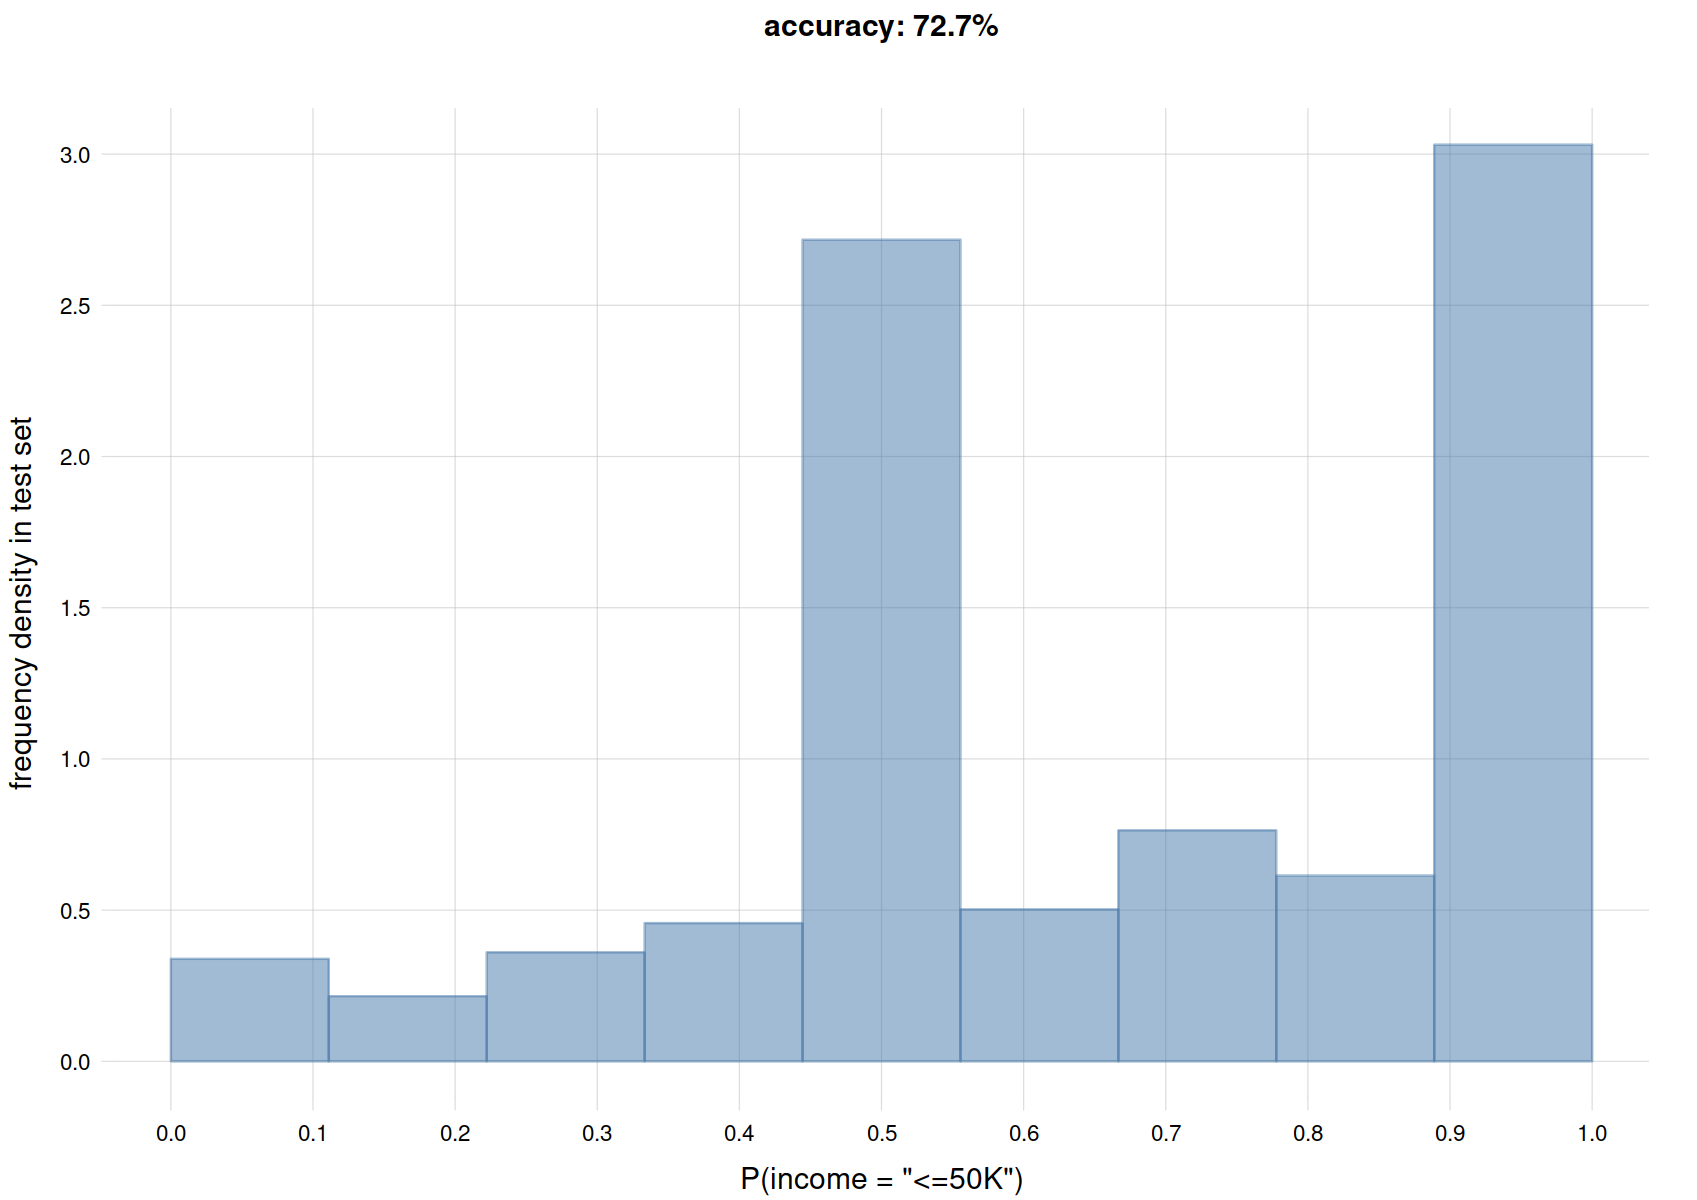

In [24]:
## Load test data
testdata <- fread('test-income_data_example.csv', header=TRUE)
ntest <- nrow(testdata) # size of test dataset

## Let's time the calculation
stopwatch <- Sys.time()

testprobs <- numeric(ntest) # prepare vector of probabilities
testhits <- numeric(ntest) # prepare vector of hits
for(i in 1:ntest){
    
    ## calculate probabilities given all variates except 'income'
    probs <- infer(agent=opmall, predictor=testdata[i, !'income'])

    ## store the probability for <=50K
    testprobs[i] <- probs['<=50K']

    ## decide on one value
    chosenvalue <- decide(probs=probs)

    ## check if decision == true_value, and store result
    testhits[i] <- (chosenvalue == testdata[i, 'income'])
}

## Print total time required
print(Sys.time() - stopwatch)

## Histogram and average accuracy (rounded to one decimal)
thist(testprobs, n=seq(0,1,length.out=10), plot=TRUE,
      xlab='P(income = "<=50K")',
      ylab='frequency density in test set',
      main=paste0('accuracy: ', round(100*mean(testhits), 1), '%'))


----

## **EXERCISE**

Now try to use a popular machine-learning algorithm for the same task, using the same training data, and compare it with the prototype optimal predictor machine. Examine the differences. For example:

- Can you inform the algorithm that $\mathit{native\_country}$ has two additional values $\verb|Norway|$, $\verb|Netherlands|$ not present in the training data? How?

- Can you flexibly use the algorithm to specify any predictors and any predictands on the fly?

- Does the algorithm inform you of how the inferences could change if more training data were available?

- Which accuracy does the algorithm achieve on the test set?

----
